In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d utkarshsaxenadn/flower-classification-5-classes-roselilyetc

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/flower-classification-5-classes-roselilyetc
License(s): CC0-1.0
flower-classification-5-classes-roselilyetc.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flower-classification-5-classes-roselilyetc.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
data_dir = '/content/Flower Classification/Flower Classification/Training Data'
sub_dir = os.listdir(data_dir)

for dir in sub_dir:
  files = os.listdir(os.path.join(data_dir, dir)) # List files in each subdirectory
  print('Total in ' + dir + ' is ' + str(len(files)))

Total in Lavender is 1000
Total in Daisy is 1000
Total in Lily is 1000
Total in Rose is 1000
Total in Sunflower is 1000


In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = data_dir,
    seed = 123,
    batch_size = 32,
    image_size = (256, 256)
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Flower Classification/Flower Classification/Validation Data',
    seed = 123,
    batch_size = 32,
    image_size = (256, 256)
)

Found 5000 files belonging to 5 classes.
Found 2500 files belonging to 5 classes.


In [ ]:
flower_names = train_ds.class_names
print(flower_names)

['Daisy', 'Lavender', 'Lily', 'Rose', 'Sunflower']


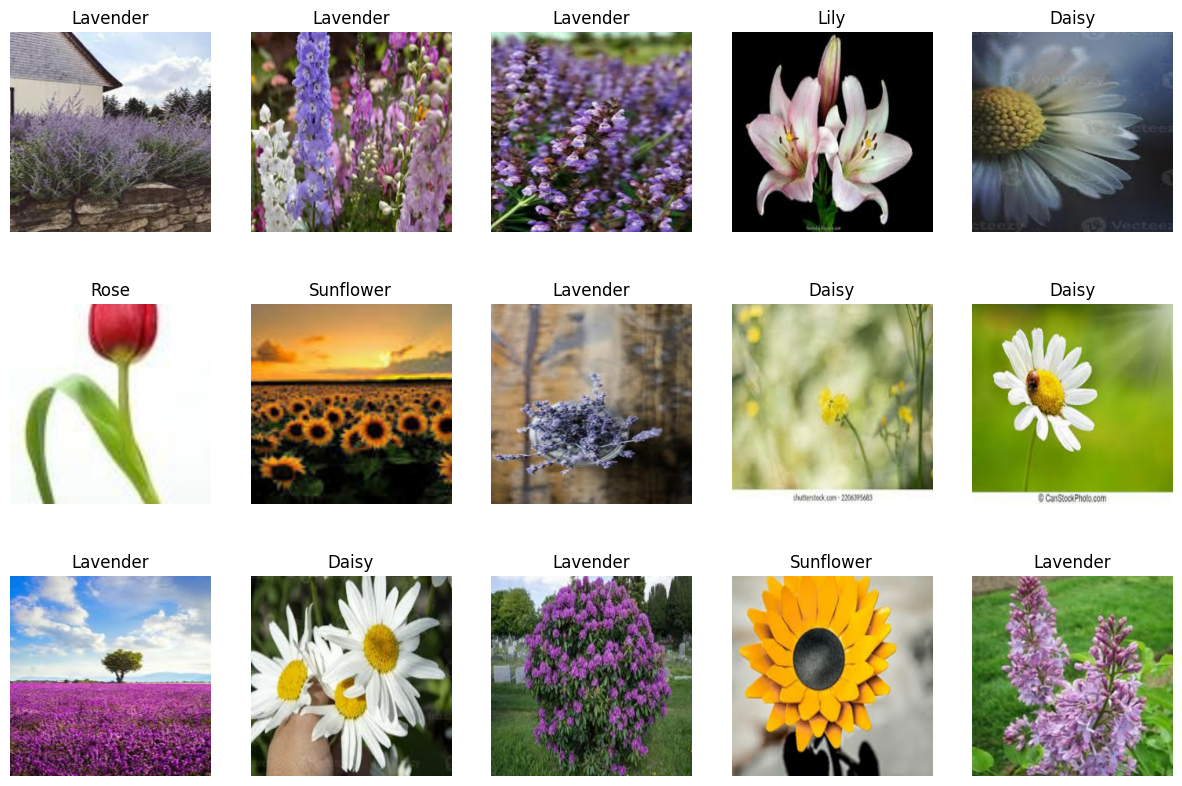

In [ ]:
i = 0
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(flower_names[labels[i]])
    plt.axis('off')

In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.1)
])

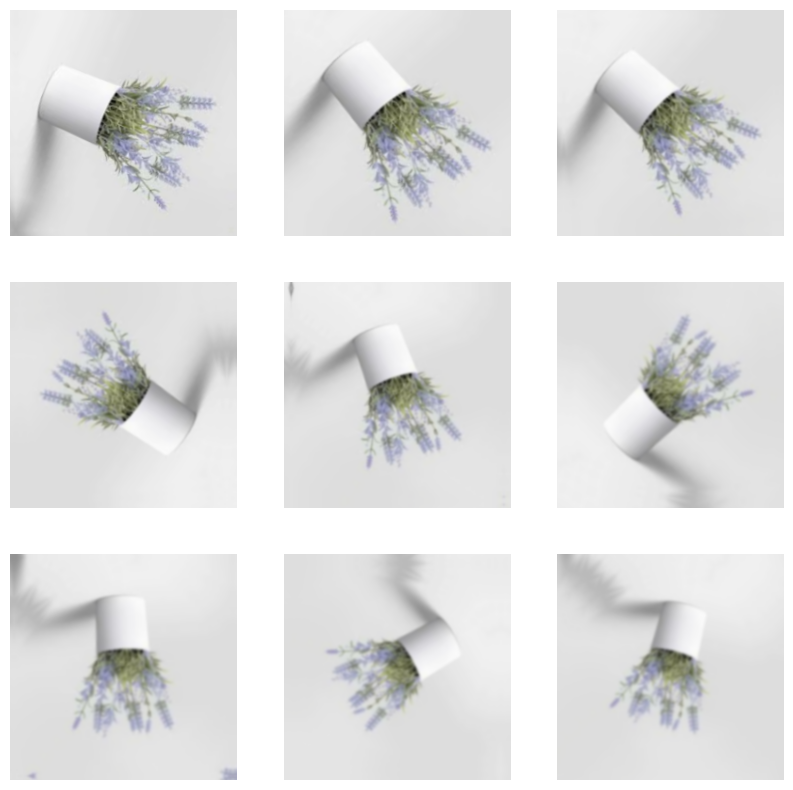

In [ ]:
i = 0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = Sequential([
    keras.layers.InputLayer(input_shape=(256, 256, 3)),
    data_augmentation,
    keras.layers.Rescaling(1./255),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,649,221 (128.36 MB)

 Trainable params: 33,649,221 (128.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
    )

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.4479 - loss: 2.5615 - val_accuracy: 0.7048 - val_loss: 0.8154
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.6875 - loss: 0.8275 - val_accuracy: 0.7000 - val_loss: 0.8091
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7200 - loss: 0.7495 - val_accuracy: 0.7488 - val_loss: 0.6470
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.7438 - loss: 0.6869 - val_accuracy: 0.7816 - val_loss: 0.5834
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.7591 - loss: 0.6320 - val_accuracy: 0.7804 - val_loss: 0.5898
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.7825 - loss: 0.5816 - val_accuracy: 0.7800 - val_loss: 0.6028
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.7921 - loss: 0.5886 - val_accuracy: 0.7800 - val_loss: 0.5551
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.7871 - loss: 0.5771 -

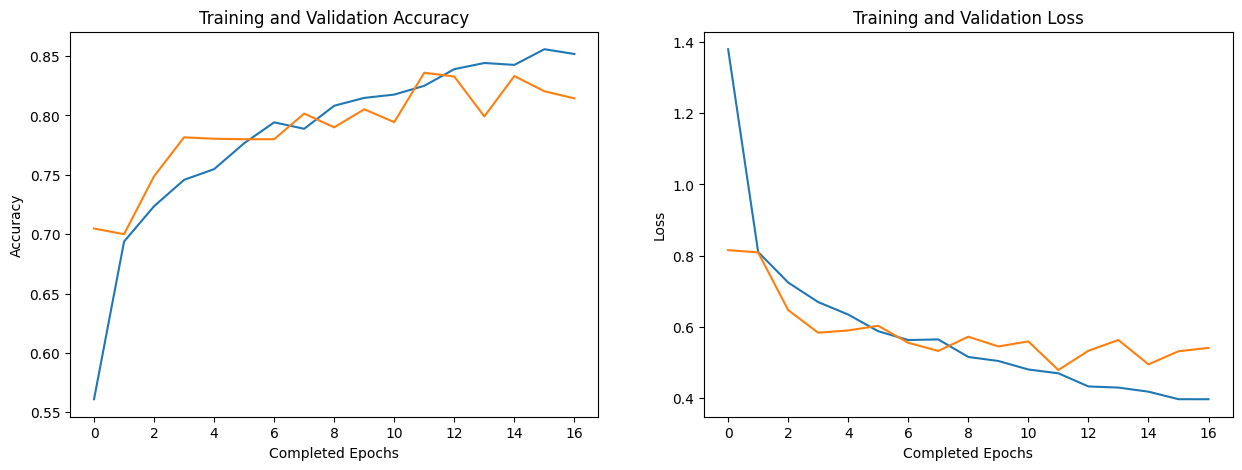

In [ ]:
def vis_logs(model):
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel("Completed Epochs")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel("Completed Epochs")
    plt.ylabel("Loss")
    plt.show()

vis_logs(history)

To futher better our model we will apply techniques like regularization and also adding dropout layers.

In [ ]:
model_2 = Sequential([
    keras.layers.InputLayer(input_shape=(256, 256, 3)),
    data_augmentation,
    keras.layers.Rescaling(1./255),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(5, activation='softmax')
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 45)                  │          11,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,659,501 (128.40 MB)

 Trainable params: 33,659,501 (128.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_2.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.3896 - loss: 1.5888 - val_accuracy: 0.6276 - val_loss: 0.9397 - learning_rate: 1.0000e-04
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.6298 - loss: 0.9320 - val_accuracy: 0.7236 - val_loss: 0.7356 - learning_rate: 1.0000e-04
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.6951 - loss: 0.8001 - val_accuracy: 0.7348 - val_loss: 0.7044 - learning_rate: 1.0000e-04
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.7227 - loss: 0.7516 - val_accuracy: 0.7384 - val_loss: 0.6772 - learning_rate: 1.0000e-04
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.7365 - loss: 0.7091 - val_accuracy: 0.7404 - val_loss: 0.6654 - learning_rate: 1.0000e-04
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.7366 - loss: 0.6870 - val_accuracy: 0.7584 - val_loss: 0.6247 - learning_rate: 1.0000e-04
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/ste

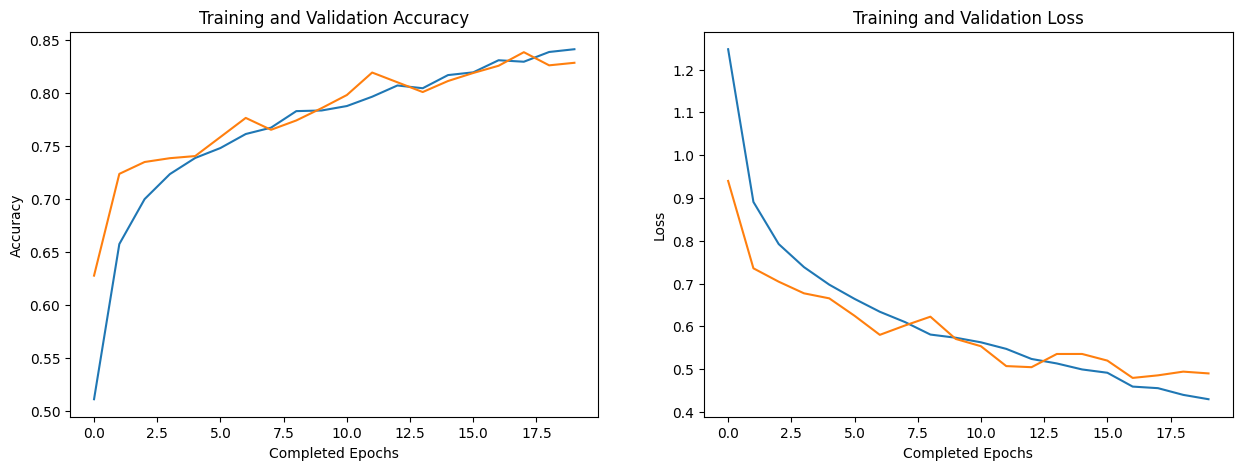

In [ ]:
vis_logs(history_2)

In [ ]:
#Training set Accuracy
train_loss, train_acc = model.evaluate(train_ds)
print('Training accuracy:', train_acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8409 - loss: 0.4310
Training accuracy: 0.8452000021934509


In [ ]:
#Validation set Accuracy
val_loss, val_acc = model.evaluate(val_ds)
print('Validation accuracy:', val_acc)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8196 - loss: 0.5092
Validation accuracy: 0.8144000172615051


In [ ]:
#Training set Accuracy
train_loss, train_acc = model_2.evaluate(train_ds)
print('Training accuracy:', train_acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8757 - loss: 0.3657
Training accuracy: 0.8654000163078308


In [ ]:
#Validation set Accuracy
val_loss, val_acc = model_2.evaluate(val_ds)
print('Validation accuracy:', val_acc)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8296 - loss: 0.4707
Validation accuracy: 0.8284000158309937


In [ ]:
model.save('flower_classification_model.h5')

In [ ]:
model_2.save('flower_classification_model_2.h5')

In [ ]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(256, 256))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array, axis=0)

    predictions = model_2.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to' + ' ' + flower_names[np.argmax(result)] + ' ' + 'with a ' + ' ' + str(round(100 * np.max(result), 2)) + '%'
    return outcome


In [ ]:
classify_images('/content/Flower Classification/Flower Classification/Testing Data/Sunflower/sunflower (116).jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'The Image belongs to Sunflower with a  5.78%'